In [1]:
from collections import Counter
from pathlib import Path
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
from imutils.paths import list_files
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import *
import torch.optim as optim
from tqdm.auto import tqdm
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np
import librosa
import torch
import timm
import cv2

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/MusicGenre'

args              = {}
args['seed']      = 99
args['n_samples'] = 3
args['device']    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['hz']        = 20000

args['bs']        = 64
args['lr']        = 7e-4
args['epochs']    = 100
args              = edict(args)

In [3]:
def show_distribution(labels, ax):
    
    cnt = Counter(labels)
    ax.bar(cnt.keys(), cnt.values())
    
    for k, v in cnt.items():
        
        ax.text(k, v, v,
                 ha = 'center', va = 'bottom')
        ax.set_ylim(0, v + 10)
        
        
def show_spectrum(wav_path, ax, lb):
    
    wav, _   = librosa.core.load(wav_path, sr = args.hz)
    amp      = librosa.stft(wav)
    spectrum = librosa.amplitude_to_db(np.abs(amp))[::-1]
    spectrum = cv2.resize(spectrum, (299, 299), interpolation = cv2.INTER_AREA)
    print(spectrum.shape)
    
    ax.imshow(spectrum, cmap = 'gray')
    ax.axis(False)
    ax.set_title(lb)
    
    
def multi_roc_auc_score(gt, pred, average = 'macro'):
    
    src_lb       = set(gt)
    roc_auc_dict = {}
    
    for label in src_lb:
        dst_lb      = [lb for lb in src_lb if lb != label]
        new_gt_lb   = [0 if lb in dst_lb else 1 for lb in gt]
        new_pred_lb = [0 if lb in dst_lb else 1 for lb in pred]
        
        roc_auc                     = roc_auc_score(new_gt_lb, new_pred_lb, average = average)
        roc_auc_dict[idx2lb[label]] = f'{roc_auc:.2f}'
        
    return roc_auc_dict
        

In [4]:
class WavDataset(Dataset):
    
    def __init__(self, paths):
        
        self.images, self.labels = self.audio2image(paths)
        
    
    def audio2image(self, paths):
    
        images, labels = [], []

        for path in paths:

            try:

                label    = lb2idx[path.split(SEP)[-2]]
                wav, _   = librosa.core.load(path,sr = args.hz)
                amp      = librosa.stft(wav)

                spectrum = librosa.amplitude_to_db(np.abs(amp))[::-1]
                spectrum = cv2.resize(spectrum, (299, 299), interpolation = cv2.INTER_AREA)

                images.append(spectrum)
                labels.append(label)

            except Exception as e: print(e)

        return np.array(images), labels
    
    
    def __len__(self):
        return len(self.labels)
    
    
    def __getitem__(self, idx):
        
        image     = self.images[idx]
        transform = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.ToTensor()
                    ])

        return transform(image), self.labels[idx]


In [5]:
class WavNet(nn.Module):
    
    def __init__(self, n_classes):
        
        super(WavNet, self).__init__()
        self.conv1 = nn.Conv2d(1,  8, kernel_size = 3, stride = 1, padding = 1)
        self.bn1   = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1)
        self.bn2   = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn3   = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn4   = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn5   = nn.BatchNorm2d(32)
        
        self.conv6 = nn.Conv2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.bn6   = nn.BatchNorm2d(16)
        
        self.fc1     = nn.Linear(16 * 4 * 4, 16)
        self.fc2     = nn.Linear(16, 32)
        self.fc3     = nn.Linear(32, n_classes)
        self.dropout = nn.Dropout2d(p = 0.5)
        
        
        
    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size = 2))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size = 2))
        x = self.bn2(x)
        
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size = 2))
        x = self.bn3(x)
        
        x = F.relu(F.max_pool2d(self.conv4(x), kernel_size = 2))
        x = self.bn4(x)
        
        x = F.relu(F.max_pool2d(self.conv5(x), kernel_size = 2))
        x = self.bn5(x)
        
        x = F.relu(F.max_pool2d(self.conv6(x), kernel_size = 2))
        x = self.bn6(x)
        
        x = x.view(-1, 16 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim = 1)

In [6]:
def train(model, loader, optimizer):
    
    model.train()
    correct, losses = 0, 0
    
    for image, label in loader:
        
        optimizer.zero_grad()
        image, label = image.to(args.device), label.to(args.device)
        output       = model(image)
        
        loss         = loss_func(output, label)
        pred         = output.max(1, keepdim = True)[1]
        
        loss.backward()
        optimizer.step()
        
        losses  += loss.item()
        correct += pred.eq(label.view_as(pred)).sum().item()
        
    
    accuracy = correct * 100 / len(loader.dataset)
    losses   = losses / len(loader.dataset)
    
    return accuracy, losses


def validation(model, loader):
    
    model.eval()
    correct, losses = 0, 0
    
    with torch.no_grad():
        for image, label in loader:
            
            image, label = image.to(args.device), label.to(args.device)
            output       = model(image)
            
            loss         = loss_func(output, label)
            pred         = output.max(1, keepdim = True)[1]
            
            losses      += loss.item()
            correct     += pred.eq(label.view_as(pred)).sum().item()
            
    
    accuracy = correct * 100 / len(loader.dataset)
    losses   = losses / len(loader.dataset)
    
    return accuracy, losses

In [7]:
wav_paths = sorted(list_files(f'{DATA_PATH}/genres_original', validExts = '.wav'))
labels    = [path.split(SEP)[-2] for path in wav_paths]

lb2idx    = {lb  : idx for idx, lb in enumerate(set(labels))}
idx2lb    = {idx : lb for lb, idx in lb2idx.items() }
lb2idx, idx2lb

({'reggae': 0,
  'hiphop': 1,
  'rock': 2,
  'blues': 3,
  'pop': 4,
  'classical': 5,
  'country': 6,
  'jazz': 7,
  'metal': 8,
  'disco': 9},
 {0: 'reggae',
  1: 'hiphop',
  2: 'rock',
  3: 'blues',
  4: 'pop',
  5: 'classical',
  6: 'country',
  7: 'jazz',
  8: 'metal',
  9: 'disco'})

In [8]:
train_x, valid_x, train_y, valid_y = train_test_split(wav_paths, labels, test_size = 0.1, shuffle = True,
                                                     stratify = labels, random_state = args.seed)

train_x, test_x, train_y, test_y   = train_test_split(train_x, train_y, test_size = 1/9, shuffle = True,
                                                      stratify = train_y, random_state = args.seed)

len(train_x), len(valid_x), len(test_x)

(800, 100, 100)

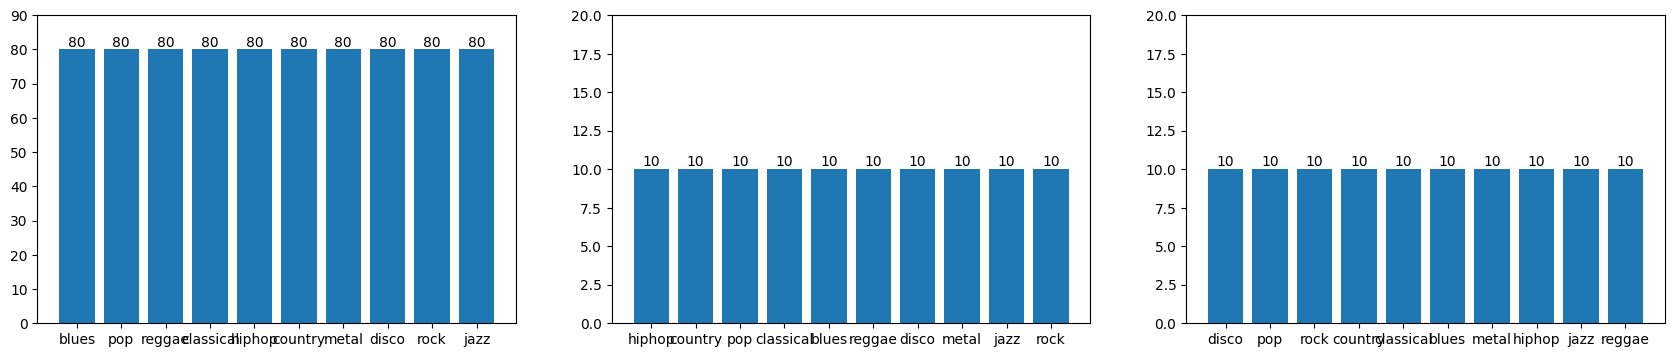

In [9]:
_, axes = plt.subplots(1, 3, figsize = (21, 4))
for lb, ax in zip([train_y, valid_y, test_y], axes):
    
    show_distribution(lb, ax)

(299, 299)
(299, 299)
(299, 299)


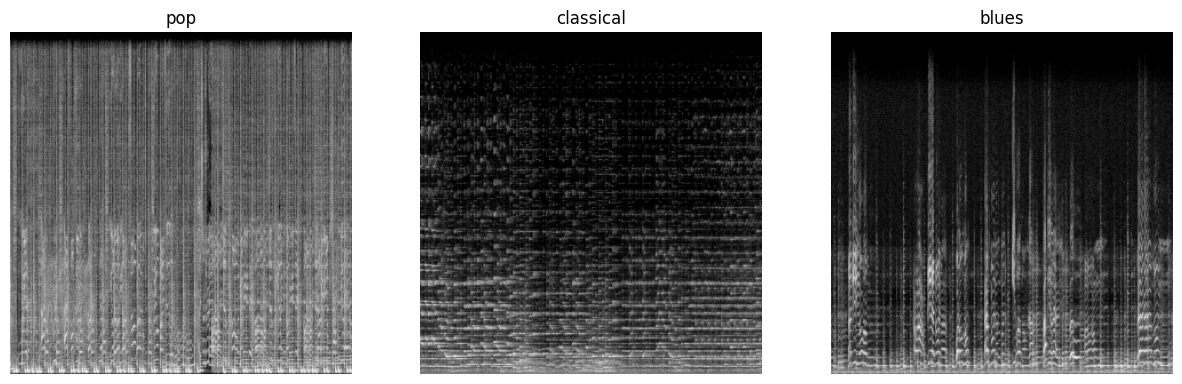

In [10]:
sample_idx = np.random.randint(0, len(wav_paths), args.n_samples)
_, axes    = plt.subplots(1, args.n_samples, figsize = (5 * args.n_samples, 5))

for idx, ax in zip(sample_idx, axes):
    
    path   = wav_paths[idx]
    label  = labels[idx]
    
    show_spectrum(path, ax, label)

In [11]:
train_dataset = WavDataset(train_x)
test_dataset  = WavDataset(test_x)
valid_dataset = WavDataset(valid_x)

train_loader  = DataLoader(train_dataset, batch_size = args.bs, shuffle =  True)
test_loader   = DataLoader(test_dataset , batch_size = args.bs, shuffle = False)
valid_loader  = DataLoader(valid_dataset, batch_size = 1, shuffle = False)

/tmp/ipykernel_379761/2609769110.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, _   = librosa.core.load(path,sr = args.hz)
/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Text(0.5, 1.0, 'tensor(8)')

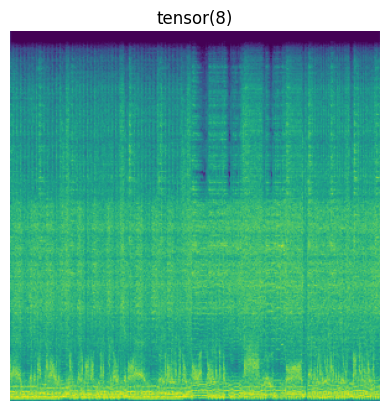

In [12]:
train_sample  = next(iter(train_loader))
image, label  = train_sample
plt.imshow(image[0].numpy().transpose(1, 2, 0))
plt.axis(False)
plt.title(label[0])

In [13]:
model     = WavNet(n_classes = len(set(labels))).to(args.device)
optimizer = optim.Adam(model.parameters(), lr = args.lr)
loss_func = nn.CrossEntropyLoss()

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [14]:
best_acc, best_model = -1e-9, None 
best_epoch = 0

for epoch in range(1, args.epochs + 1):
    
    train_acc, train_loss = train(model, train_loader, optimizer)
    test_acc , test_loss  = validation(model, test_loader)
        
    print(f'[{epoch} / {args.epochs}]')
    print(f'[TRAIN] loss : {train_loss:.3f}, acc : {train_acc:.3f}%')
    print(f'[TEST]  loss : {test_loss:.3f}, acc : {test_acc:.3f}%')
    
    if (test_acc >= best_acc) and (best_epoch < epoch):
        best_acc   = test_acc
        best_model = model
        best_epoch = epoch
        print(f'[best model with {test_acc:.3f}%]\n')

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1 / 100]
[TRAIN] loss : 0.037, acc : 13.892%
[TEST]  loss : 0.046, acc : 10.000%
[best model with 10.000%]

[2 / 100]
[TRAIN] loss : 0.036, acc : 18.273%
[TEST]  loss : 0.044, acc : 23.000%
[best model with 23.000%]

[3 / 100]
[TRAIN] loss : 0.035, acc : 22.528%
[TEST]  loss : 0.042, acc : 39.000%
[best model with 39.000%]

[4 / 100]
[TRAIN] loss : 0.034, acc : 22.403%
[TEST]  loss : 0.040, acc : 36.000%
[5 / 100]
[TRAIN] loss : 0.033, acc : 24.781%
[TEST]  loss : 0.040, acc : 31.000%
[6 / 100]
[TRAIN] loss : 0.032, acc : 24.531%
[TEST]  loss : 0.038, acc : 39.000%
[best model with 39.000%]

[7 / 100]
[TRAIN] loss : 0.032, acc : 28.285%
[TEST]  loss : 0.037, acc : 38.000%
[8 / 100]
[TRAIN] loss : 0.031, acc : 31.289%
[TEST]  loss : 0.035, acc : 43.000%
[best model with 43.000%]

[9 / 100]
[TRAIN] loss : 0.029, acc : 35.044%
[TEST]  loss : 0.035, acc : 45.000%
[best model with 45.000%]

[10 / 100]
[TRAIN] loss : 0.030, acc : 31.539%
[TEST]  loss : 0.035, acc : 45.000%
[best model with 

[TEST] accuracy : 0.66
roc auc score for each labels : {'reggae': '0.89', 'hiphop': '0.79', 'rock': '0.57', 'blues': '0.82', 'pop': '0.93', 'classical': '0.85', 'country': '0.86', 'jazz': '0.94', 'metal': '0.90', 'disco': '0.55'}
              precision    recall  f1-score   support

      reggae       0.47      0.90      0.62        10
      hiphop       0.75      0.60      0.67        10
        rock       0.29      0.20      0.24        10
       blues       0.58      0.70      0.64        10
         pop       0.75      0.90      0.82        10
   classical       1.00      0.70      0.82        10
     country       0.53      0.80      0.64        10
        jazz       0.82      0.90      0.86        10
       metal       1.00      0.80      0.89        10
       disco       1.00      0.10      0.18        10

    accuracy                           0.66       100
   macro avg       0.72      0.66      0.64       100
weighted avg       0.72      0.66      0.64       100



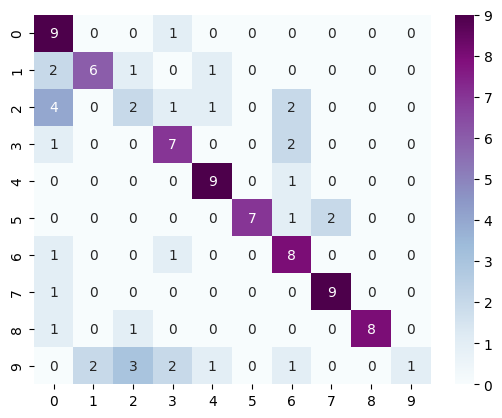

In [15]:
best_model.eval()
gt, preds = [], []

with torch.no_grad():
    
    for image, label in valid_loader:
        
        image  = image.to(args.device)
        label  = label.to(args.device)
        
        pred   = best_model(image).max(1, keepdim = True)[1]
        
        gt.extend(label.detach().cpu().numpy())
        preds.extend(pred.detach().cpu().numpy())


conf_mat = confusion_matrix(gt,preds)
sns.heatmap(conf_mat,annot = True, cmap = 'BuPu')

print(f'[TEST] accuracy : {accuracy_score(gt, preds)}')
print(f'roc auc score for each labels : {multi_roc_auc_score(gt, preds)}')
print(classification_report(gt, preds, target_names = lb2idx.keys()))